In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_validate, RandomizedSearchCV, train_test_split
import optuna
import xgboost as xgb
from sklearn.metrics import r2_score 
import joblib

In [2]:
df2 = pd.read_excel("../markaFile/Mazda.xlsx",sheet_name="Sheet1")

In [3]:
df2.drop("Unnamed: 0",axis=1, inplace=True)

In [4]:
df2.head()

,Fiyat,Yıl,Motor Gücü,Motor Hacmi,Kilometre,Boya,Değişen,Seri_121,Seri_2,Seri_3,...,Model_2.0 TE,Model_2.0i SKYACTIVE-G Power Sense,Model_MX-5 1.5,Model_MX-5 2.0,Model_RX-8 1.3,Yakıt Tipi_Benzin,Yakıt Tipi_Dizel,Yakıt Tipi_LPG & Benzin,Vites Tipi_Düz,Vites Tipi_Otomatik
0,1420000,2020,165,1998,8500,0.0,0.0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
1,395000,2005,105,1598,170000,NaN,NaN,0,0,1,...,0,0,0,0,0,0,0,1,0,1
2,370000,2005,105,1598,246000,5.0,0.0,0,0,1,...,0,0,0,0,0,0,0,1,0,1
3,182000,1998,122,1840,260000,NaN,NaN,0,0,0,...,0,0,0,0,0,0,0,1,1,0
4,730000,2014,120,1496,167000,1.0,0.0,0,0,1,...,0,0,0,0,0,1,0,0,0,1


In [5]:
y = df2["Fiyat"]
X = df2.drop(["Fiyat"], axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [7]:
def set_model(model_list, X_train, X_test, y_train, y_test):
    dataf = pd.DataFrame()

    for i in range(len(model_list)):
        algo_name = model_list[i][0]
        algo = model_list[i][1]

        model = algo.fit(X_train, y_train)

        cv_result = cross_val_score(model,
                                    X_train, y_train,
                                    cv=5,
                                    scoring="neg_mean_squared_error")

        y_pred = model.predict(X_test)
        rmse = np.mean(np.sqrt(-cv_result))
        data_list = {"Model": algo_name,
                     "TestDeger": rmse,
                     "MSE":mean_squared_error(y_test, y_pred),
                     "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
                     "MAE": mean_absolute_error(y_test, y_pred)}
        dataf = dataf.append(data_list, ignore_index=True)

    return dataf

In [8]:
models = []
#models.append(('Gradient Boosting Regressor', GradientBoostingRegressor()))
models.append(('XGBModel', XGBRegressor(objective="reg:squarederror",use_label_encoder=False)))
#models.append(('LGBMModel', LGBMRegressor(use_missing=False)))
#models.append(('LRModel', LinearRegression()))
#models.append(('RFModel', RandomForestRegressor()))

In [9]:
df2_model = set_model(models, X_train, X_test, y_train, y_test)
df2_model

C:\Users\senab\AppData\Local\Temp\ipykernel_13336\3059390516.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataf = dataf.append(data_list, ignore_index=True)


,Model,TestDeger,MSE,RMSE,MAE
0,XGBModel,70027.793368,4.085185e+09,63915.453752,44962.319028


In [10]:
def objective(n_trials):
  params = {
        'colsample_bytree': n_trials.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': n_trials.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        "learning_rate": n_trials.suggest_float("learning_rate", 1e-4, 0.5, log=True),
        'n_estimators': 10000,
        "max_depth": n_trials.suggest_int("max_depth", 3, 15),
        'min_child_weight': n_trials.suggest_int('min_child_weight', 1, 300),
    }
  dtrain = xgb.DMatrix(data = X_train, label = y_train)
  dval = xgb.DMatrix(data = X_test, label = y_test)

  regressor = xgb.train(params, dtrain) 
  y_pred = regressor.predict(dval)
  rmse = mean_squared_error(y_test, y_pred, squared=False)

  return rmse

In [11]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=250, n_jobs=-1)

[I 2023-10-08 14:15:42,299] A new study created in memory with name: no-name-1297efb0-e6de-47a3-8856-f3ed5b69477c
[I 2023-10-08 14:15:42,429] Trial 0 finished with value: 452206.7037063497 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.0007541457058846566, 'max_depth': 4, 'min_child_weight': 174}. Best is trial 0 with value: 452206.7037063497.
[I 2023-10-08 14:15:42,445] Trial 1 finished with value: 452206.7037063497 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.00012920381366989211, 'max_depth': 14, 'min_child_weight': 184}. Best is trial 0 with value: 452206.7037063497.
[I 2023-10-08 14:15:42,445] Trial 4 finished with value: 452206.7037063497 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.3958783535888525, 'max_depth': 3, 'min_child_weight': 166}. Best is trial 0 with value: 452206.7037063497.
[I 2023-10-08 14:15:42,445] Trial 2 finished with value: 452206.7037063497 and parameters: {'co

[I 2023-10-08 14:15:43,557] Trial 30 finished with value: 381237.7478061175 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.1314903690657332, 'max_depth': 12, 'min_child_weight': 72}. Best is trial 25 with value: 209553.9499327378.
[I 2023-10-08 14:15:43,564] Trial 31 finished with value: 411297.0654602599 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.133219803151589, 'max_depth': 9, 'min_child_weight': 75}. Best is trial 25 with value: 209553.9499327378.
[I 2023-10-08 14:15:43,689] Trial 32 finished with value: 452206.7037063497 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.17925314747210863, 'max_depth': 13, 'min_child_weight': 77}. Best is trial 25 with value: 209553.9499327378.
[I 2023-10-08 14:15:43,778] Trial 33 finished with value: 452206.7037063497 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.1556343536616042, 'max_depth': 13, 'min_child_weight': 76

[I 2023-10-08 14:15:45,560] Trial 61 finished with value: 108515.47391617714 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.25877151413675387, 'max_depth': 5, 'min_child_weight': 27}. Best is trial 54 with value: 100431.18118272927.
[I 2023-10-08 14:15:45,560] Trial 60 finished with value: 106545.02847596537 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.2456968906446649, 'max_depth': 5, 'min_child_weight': 26}. Best is trial 54 with value: 100431.18118272927.
[I 2023-10-08 14:15:45,638] Trial 62 finished with value: 107441.37556029385 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.23390182932573686, 'max_depth': 4, 'min_child_weight': 23}. Best is trial 54 with value: 100431.18118272927.
[I 2023-10-08 14:15:45,669] Trial 64 finished with value: 228703.2313141344 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.2115235009957715, 'max_depth': 5, 'min_child_weight

[I 2023-10-08 14:15:47,265] Trial 90 finished with value: 75568.52870782977 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.33633293167270006, 'max_depth': 3, 'min_child_weight': 1}. Best is trial 88 with value: 63019.9646819936.
[I 2023-10-08 14:15:47,480] Trial 94 finished with value: 134962.6596046713 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.1372506181815986, 'max_depth': 6, 'min_child_weight': 12}. Best is trial 88 with value: 63019.9646819936.
[I 2023-10-08 14:15:47,483] Trial 91 finished with value: 138636.21997118244 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.1329211033731087, 'max_depth': 6, 'min_child_weight': 9}. Best is trial 88 with value: 63019.9646819936.
[I 2023-10-08 14:15:47,503] Trial 92 finished with value: 80682.14540463817 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.3539685657704362, 'max_depth': 6, 'min_child_weight': 11}. Bes

[I 2023-10-08 14:15:49,205] Trial 120 finished with value: 96013.49564447165 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.4065174628930298, 'max_depth': 4, 'min_child_weight': 20}. Best is trial 88 with value: 63019.9646819936.
[I 2023-10-08 14:15:49,252] Trial 121 finished with value: 96015.18171422543 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.397325156773927, 'max_depth': 4, 'min_child_weight': 21}. Best is trial 88 with value: 63019.9646819936.
[I 2023-10-08 14:15:49,406] Trial 122 finished with value: 66892.61995476263 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.4169556993463336, 'max_depth': 4, 'min_child_weight': 6}. Best is trial 88 with value: 63019.9646819936.
[I 2023-10-08 14:15:49,568] Trial 124 finished with value: 63292.56091185533 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.47105283585059304, 'max_depth': 5, 'min_child_weight': 5}. B

[I 2023-10-08 14:15:51,345] Trial 150 finished with value: 73503.58662858956 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.3800505253887241, 'max_depth': 4, 'min_child_weight': 6}. Best is trial 128 with value: 62383.28126140015.
[I 2023-10-08 14:15:51,457] Trial 151 finished with value: 67613.8653174957 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.3841876466959856, 'max_depth': 4, 'min_child_weight': 7}. Best is trial 128 with value: 62383.28126140015.
[I 2023-10-08 14:15:51,521] Trial 152 finished with value: 82230.30471054008 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.37877759927203936, 'max_depth': 4, 'min_child_weight': 14}. Best is trial 128 with value: 62383.28126140015.
[I 2023-10-08 14:15:51,609] Trial 153 finished with value: 86775.20610774607 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.378432706153928, 'max_depth': 4, 'min_child_weight': 1

[I 2023-10-08 14:15:53,657] Trial 181 finished with value: 90169.84510521767 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.407316394037658, 'max_depth': 4, 'min_child_weight': 16}. Best is trial 128 with value: 62383.28126140015.
[I 2023-10-08 14:15:53,705] Trial 180 finished with value: 90736.9370142458 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.38773394631245367, 'max_depth': 4, 'min_child_weight': 16}. Best is trial 128 with value: 62383.28126140015.
[I 2023-10-08 14:15:53,729] Trial 182 finished with value: 68714.50503775566 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.40256365004392003, 'max_depth': 4, 'min_child_weight': 9}. Best is trial 128 with value: 62383.28126140015.
[I 2023-10-08 14:15:53,849] Trial 183 finished with value: 404358.7991939191 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.012763574742420744, 'max_depth': 4, 'min_child_weight

[I 2023-10-08 14:15:55,927] Trial 210 finished with value: 93900.08595441129 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.28128319453641354, 'max_depth': 3, 'min_child_weight': 18}. Best is trial 128 with value: 62383.28126140015.
[I 2023-10-08 14:15:56,061] Trial 211 finished with value: 93394.85665147097 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.2864302178400681, 'max_depth': 3, 'min_child_weight': 18}. Best is trial 128 with value: 62383.28126140015.
[I 2023-10-08 14:15:56,080] Trial 212 finished with value: 80235.90575155725 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.28044445824421826, 'max_depth': 3, 'min_child_weight': 12}. Best is trial 128 with value: 62383.28126140015.
[I 2023-10-08 14:15:56,191] Trial 213 finished with value: 113498.98432557864 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.16139674832416806, 'max_depth': 3, 'min_child_wei

[I 2023-10-08 14:15:58,451] Trial 240 finished with value: 70648.33708935327 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.36980208535822373, 'max_depth': 4, 'min_child_weight': 7}. Best is trial 128 with value: 62383.28126140015.
[I 2023-10-08 14:15:58,535] Trial 242 finished with value: 71492.32741018286 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.36215159413957854, 'max_depth': 4, 'min_child_weight': 7}. Best is trial 128 with value: 62383.28126140015.
[I 2023-10-08 14:15:58,556] Trial 241 finished with value: 61261.374250183755 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.4992299136309873, 'max_depth': 4, 'min_child_weight': 6}. Best is trial 241 with value: 61261.374250183755.
[I 2023-10-08 14:15:58,660] Trial 244 finished with value: 69109.19124323745 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.3529540995529641, 'max_depth': 5, 'min_child_weight

In [12]:
print(f"Optimized RMSE: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized RMSE: 58816.1371
Best params:
	colsample_bytree: 0.9
	subsample: 0.8
	learning_rate: 0.49023928784234916
	max_depth: 4
	min_child_weight: 1


In [13]:
model = XGBRegressor(objective="reg:squarederror",use_label_encoder=False)


final_model = model.set_params(**study.best_params).fit(X_train,y_train)
    
cv_results = cross_validate(final_model,
                            X_train, y_train,
                            cv=5,
                            scoring="neg_mean_squared_error")
    
y_pred = final_model.predict(X_test)

rmse = (np.sqrt(-cv_results['test_score'])).mean()
data_list = {"TestDeger": rmse,
             "MSE":mean_squared_error(y_test, y_pred),
             "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
             "MAE": mean_absolute_error(y_test, y_pred)}

print(data_list)

{'TestDeger': 77154.37943135023, 'MSE': 4355602656.479921, 'RMSE': 65996.98975316921, 'MAE': 48994.94295804795}


In [14]:
r2 = r2_score(y_test, y_pred)
r2

0.9235231331736427

In [15]:
n= len(X_train)
p =len(X.columns)
adj_R2 = 1- ((1-r2) * (n-1)/(n-p-1))
adj_R2

0.8727909541898214

In [16]:
marka_model = joblib.dump(final_model, "Mazda.pkl")

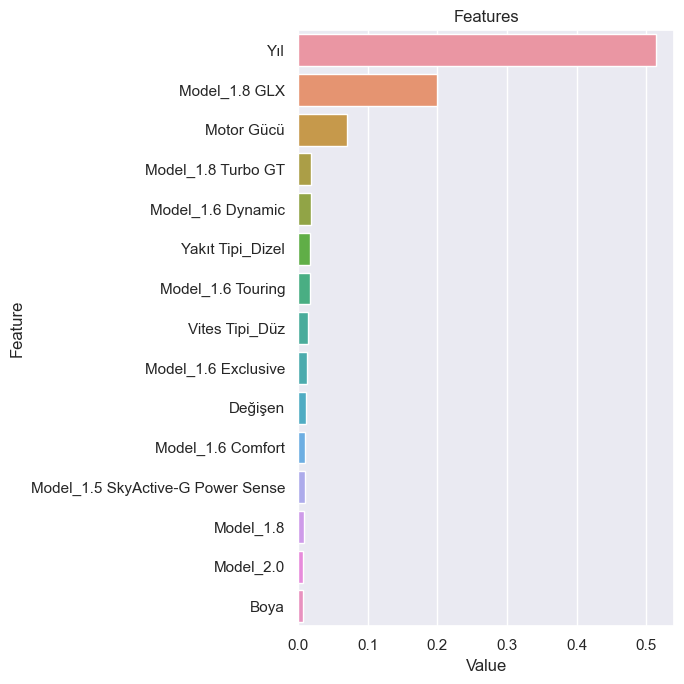

In [17]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:15])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")
plot_importance(final_model,X)